In [1]:
import requests
import requests_cache
import pandas as pd
import numpy as np
import time
import string
import seaborn as sns
from itertools import compress
from plotnine import *

In [2]:
requests_cache.install_cache("ndb_cache")

In [3]:
# read in my api key
def read_key(keyfile):
    with open(keyfile) as f:
        return f.readline().strip("\n")

In [4]:
api_key = read_key("/Users/seacow/Documents/School Work/STA 141B/api_key_ndb")

In [5]:
def ndb_search(term, genre = ""):
    '''This function takes in two string arguments-- search term and food category. This function will search the 
    string through https://api.nal.usda.gov/ndb/search NOTE: Search that does not return anything will result in this function 
    outputing a empty list and the default category is [every category]'''
    response = requests.get("https://api.nal.usda.gov/ndb/search", params = {
        "api_key": api_key,
        "q": term,
        "fg": genre
    })
    
    # Check feedback
    response.raise_for_status()
    
    # Convert feedback to json format
    response = response.json()
    
    if "errors" in response.keys():
        return([])
    else:
        # get list information
        response = response['list']['item']
    
    # set time break
    time.sleep(0.2)
    
    return(response)

In [6]:
# test
# valid search
ndb_search("milk")

[{'offset': 0,
  'group': 'Branded Food Products Database',
  'name': "WEIS, BETTER'N SKIM, A NON-FAT MILK WITH THE TASTE OF 2% MILK!, SKIM MILK, UPC: 041497099535",
  'ndbno': '45236270',
  'ds': 'LI',
  'manu': 'WEIS MARKETS, INC.'},
 {'offset': 1,
  'group': 'Branded Food Products Database',
  'name': 'MILK PLEASE, MILK SPASH, MILK FLAVORING, SIR STRAWBERRY SWIRL, UPC: 728225037198',
  'ndbno': '45296052',
  'ds': 'LI',
  'manu': 'S & D Coffee, Inc.'},
 {'offset': 2,
  'group': 'Dairy and Egg Products',
  'name': 'Protein supplement, milk based, Muscle Milk, powder',
  'ndbno': '01223',
  'ds': 'SR',
  'manu': 'none'},
 {'offset': 3,
  'group': 'Sweets',
  'name': 'Milk dessert, frozen, milk-fat free, chocolate',
  'ndbno': '42131',
  'ds': 'SR',
  'manu': 'none'},
 {'offset': 4,
  'group': 'Dairy and Egg Products',
  'name': 'Protein supplement, milk based, Muscle Milk Light, powder',
  'ndbno': '01224',
  'ds': 'SR',
  'manu': 'none'},
 {'offset': 5,
  'group': 'Dairy and Egg Prod

In [7]:
# invalid search
ndb_search("Luka Doncic")

[]

__Exercise 1.2__

Use your search function to get NDB numbers for the foods in the `fresh.csv` file. It's okay if you don't get an NDB number for every food, but try to come up with a strategy that gets most of them. Discuss your strategy in a short paragraph.

Hints:

* The foods are all raw and unbranded.
* You can test search terms with the [online search page](https://ndb.nal.usda.gov/ndb/search/list).
* The [Python](https://docs.python.org/3/library/stdtypes.html#string-methods) and [Pandas](http://pandas.pydata.org/pandas-docs/stable/user_guide/text.html) string methods are useful here. It's okay if you use _simple_ regular expressions in the Pandas methods, although this exercise can be solved without them.
* You can merge data frames that have a column in common with `pd.merge()`.

In [8]:
fresh = pd.read_csv("fresh.csv")

In [9]:
fresh_core = fresh.loc[:,["form", "food", "type"]]

# modify column form
fresh_core.loc[:,"form"] = [ele.replace("Fresh", "") for ele in fresh_core.loc[:,"form"]]
fresh_core.loc[:,"form"] = [ele.replace("1", "") for ele in fresh_core.loc[:,"form"]]
fresh_core.loc[:,"form"] = [ele.replace(",", "") for ele in fresh_core.loc[:,"form"]]
fresh_core.loc[:,"form"] = [ele.replace("consumed with", "") for ele in fresh_core.loc[:,"form"]]
fresh_core.loc[:,"form"] = [ele.replace("cabbage", "") for ele in fresh_core.loc[:,"form"]]

# modify column food
fresh_core.loc[:,"food"] = [ele.replace("_", " ") for ele in fresh_core.loc[:,"food"]]

# Create column for searching
fresh_core.loc[:,"key word"] = fresh_core.loc[:,"food"] + " " + fresh_core.loc[:,"type"] + " " + fresh_core.loc[:,"form"]
fresh_keyword = fresh_core.loc[:,"key word"]

fresh_keyword = [ele.rstrip() for ele in fresh_keyword]

fresh_keyword = pd.Series(fresh_keyword)

In [10]:
def search_for_ndb(string):
    '''This function takes in a argument of string type. This string should be in the format of 
    
    "[food name] + [food type] + [food condition (only if neccessary)]". 
    
    The output of this function
    will be the corresponding ndb number of the food.'''
    
    # split given string to check each element
    string = string.split()
    string_end = string[-1]
    
    # case when there are more condition
    if string_end not in ("fruit", "vegetables"):
        condition = string[-1]
        genre = string[-2]
        food = string[:-2]
        
        # handle the case where food name contains multiple word
        if (len(food) > 1):
            seperator = ", "
            food = seperator.join(food)
            food = food.replace(",", "")
        else:
            food = food[0]
        
        # check if we are searching vege or fruit
        if genre == "vegetables":
            genre = "Vegetables and Vegetable Products"
            result = ndb_search(food, genre) 
            # in case the product's genre is wrong
            if len(result) == 0:
                genre = ""
                result = ndb_search(food, genre)
                # change key word and attemp again
                if len(result) == 0:
                    food = string[0]
                    result = ndb_search(food, genre)
        else:
            genre = "Fruits and Fruit Juices"
            result = ndb_search(food, genre)
            
            # avoid to have empty result for being too specific
            if len(result) == 0:
                genre = ""
                result = ndb_search(food, genre)
                if len(result) == 0:
                        food = string[0]
                        result = ndb_search(food, genre)
    
        # first filter
        boo = ["raw" in ele["name"] for ele in result]
        result = list(compress(result, boo))
        
        # avoid being too specific
        if len(result) == 0:
            term = string[0]
            result = ndb_search(food, genre)
        
        # make a temporary variable
        temp = result

        # second filter
        boo = [condition in ele["name"] for ele in result]
        result = list(compress(result, boo))

        # pick the best match
        try:
            result = result[0]
        except IndexError:
            result = temp[0]
        
        ndb_number = result["ndbno"]
        
        return(ndb_number)
    
    else:
        genre = string[-1]
        food = string[:-1]
        
        # handle the case where food name contains multiple word
        if (len(food) > 1):
            seperator = ","
            food = seperator.join(food)
            food = food.replace(",", " ")
        else:
            food = food[0]
        
         # check if we are searching vege or fruit
        if genre == "vegetables":
            genre = "Vegetables and Vegetable Products"
            result = ndb_search(food, genre) 
            # avoid being too specific
            if len(result) == 0:
                genre = ""
                result = ndb_search(food, genre)
                # change key word and attemp again
                if len(result) == 0:
                    food = string[0]
                    result = ndb_search(food, genre)
        else:
            genre = "Fruits and Fruit Juices"
            result = ndb_search(food, genre)
            
            # avoid to have empty result for being too specific
            if len(result) == 0:
                genre = ""
                result = ndb_search(food, genre)
                if len(result) == 0:
                        food = string[0]
                        result = ndb_search(food, genre)
                        
        # first filter
        boo = ["raw" in ele["name"] for ele in result]
        result = list(compress(result, boo))

        if len(result) == 0:
            food = string[0]
            result = ndb_search(food, genre)
            # filter again
            boo = ["raw" in ele["name"] for ele in result]
            result = list(compress(result, boo))

        # prevent index error
        try:
            result = result[0]
        except IndexError :
            print(food)
            
        # Deal with fruit "Kiwi", which returns beverage instead of raw fruit
        if result["group"] == "Beverages":
            temp = food
            seperator = ", "
            food = seperator.join(string)
            food = food.replace(",", "")
            food = food.replace(" ","")
            # restroe default genre
            genre = "Fruits and Fruit Juices"
            result = ndb_search(food, genre)[0]
        
        # get ndb number 
        ndb_number = result["ndbno"]

        return(ndb_number)

In [11]:
ndb_number = fresh_keyword.apply(search_for_ndb)

In [12]:
ndb_number

0     09326
1     09181
2     09218
3     09316
4     09279
5     09201
6     09302
7     09286
8     09266
9     09021
10    09184
11    09226
12    09148
13    09063
14    09040
15    09003
16    09236
17    09191
18    09252
19    09117
20    09042
21    09129
22    09050
23    09176
24    11011
25    11205
26    11206
27    11252
28    11282
29    11568
30    11270
31    11352
32    11161
33    11052
34    11482
35    11821
36    11109
37    11112
38    11505
39    11475
40    11429
41    11485
42    09038
43    11233
44    11007
45    11278
46    11333
47    11098
48    11900
dtype: object

In [13]:
# Add ndb number to dataset
fresh.loc[:,"ndb_number"] = ndb_number

In [14]:
fresh

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,ndb_number
0,Fresh1,0.316639,0.520000,0.330693,0.201366,watermelon,fruit,09326
1,Fresh1,0.520794,0.510000,0.374786,0.382718,cantaloupe,fruit,09181
2,Fresh1,1.480396,0.740000,0.407855,0.815929,tangerines,fruit,09218
3,Fresh1,2.508450,0.940000,0.319670,0.853060,strawberries,fruit,09316
4,Fresh1,1.987999,0.940000,0.363763,0.769319,plums,fruit,09279
5,Fresh1,1.097122,0.680000,0.407855,0.658039,oranges,fruit,09201
6,Fresh1,6.877702,0.960000,0.319670,2.290205,raspberries,fruit,09302
7,Fresh1,2.078430,0.560000,0.341717,1.268275,pomegranate,fruit,09286
8,Fresh1,0.652795,0.510000,0.363763,0.465612,pineapple,fruit,09266
9,Fresh1,3.087138,0.930000,0.363763,1.207511,apricots,fruit,09021


## My General Strategy ##
For this question, my approach is based on the `.apply()` function on `Pandas` dataframe. The advantage of using `.apply()` attribute is that it garantees that the result we get is in the same order as the element in the dataset. Therefore, instead of using `.merge()` attribute, I can simply add the search result to the dataset and it will be ready to ge. To use the `.apply()` function, I first extracted all of the product name from the dataset and did some string manipulations to get the name and the type (vegetables vs. fruit) of each product. The reason I also get the type of the fuirt is that I realized that all __raw vegetables__ and __raw fruits__ have the same food group-- "Vegetables and Vegetable Products" for vegetables and "Fruits and Fruit Juices" for fruits. Therefore, by specifying the *"food group"* ("fg") parameter of the search api, I can reduce the amount of search I require from the server, which will save them money and save me time. 

With the strings set, I built a function called `search_for_ndb()` that takes in a string from the __food__ column of __fresh.csv__ dataset and return its corresponding ndb number. The search function used here is the one (`ndb_search`) I wrote for Question 1.1. By `apply` the function `search_for_ndb()` to the modified __food__ column of __fresh.csv__, I will get a list of the ndb number of the corresponding food. Here are some detailed strategies I used to solve some of the diffculties I had when building this function:

## My Detailed Strategy

* I noticed that some vegetables are in the food group of "Fruits and Fruit Juices" instead of "Vegetables and Vegetable Products". To eiliminate the errors that may occur due to the strict searching parameter (Only searching for one food gourp), the function will search for products from all food groups if the precision search returns no result (e.g. empty list `[]`). To be more secure, I also added another solution-- If the returned result is still empty after searching product in all food types, then I modified the food name to be the first words of the __food__ column of __fresh.csv__ dataset. This way, I modified both of the *food name* and *food type* parameter to do a very generalized search, which should garantee, although not going to be very precise, a searching outcome.

* When doing the string manipulation, I splited the string by whitespace and get a list of words in the string. I fisrt thought that the frist element of the list would be the name of the product and the last element would be its type. Later I realized that I have neglected the case where a product have multiple words in its name (e.g. green peppers) and product that have more detailed narration (e.g. green cabbage VS. red cabbage). Therefore, I did more string manipulations to get the narration as well as the product name right. 

* Another difficulty I encountered is that it is possible that some product does not neccessarily have the exact word "raw" in their searching result. Therefore, when narrowing search result by checking if the word "raw" is in the __"name"__ category of the returned __JSON__ data, it might eliminate all possible result. Therefore, my solution is to add another check after narrowing search result-- if there is no element that contains the word "raw", then I will simply select the first search result as it is the best match in this case. Same approach is used when getting product with detailed conditions (e.g. peel vs. peeled). To avoid returning an empty list, a check is also added after filtering the condition. 

* The food __"kiwi"__ is a problematic term to search for. First of all, when filtering the word "raw" in the search result, results that contain "strawberry" is not filtered, which leads to the result of getting the ndb number for a kiwi beverage instead of the fruit kiwi. To deal with this case, I added another lyer of filter by checking if the __"food group"__ category of the search result is "Beverages". If it is, I will combine the food name and food type together to make a more precise search.

__Exercise 1.3__

Read the [food reports V2 documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-FOOD-REPORTV2.md), then write a function called `ndb_report()` that requests a _basic_ food report. The function should accept the NDB number as an argument and return the list of nutrients for the food.

Note that the report url is: `https://api.nal.usda.gov/ndb/V2/reports`

For example, for `"09279"` (raw plums) the first element of the returned list should be:

```python
{'nutrient_id': '255',
 'name': 'Water',
 'derivation': 'NONE',
 'group': 'Proximates',
 'unit': 'g',
 'value': '87.23',
 'measures': [{'label': 'cup, sliced',
   'eqv': 165.0,
   'eunit': 'g',
   'qty': 1.0,
   'value': '143.93'},
  {'label': 'fruit (2-1/8" dia)',
   'eqv': 66.0,
   'eunit': 'g',
   'qty': 1.0,
   'value': '57.57'},
  {'label': 'NLEA serving',
   'eqv': 151.0,
   'eunit': 'g',
   'qty': 1.0,
   'value': '131.72'}]}
```

Be sure to document and test your function.

In [15]:
def ndb_report(ndb_number):
    '''This function takes in ndb number and returns a basic report of the corresponding food from the USDA websiet.
    The input ndb number should be in string format. Invalid ndb number will result in the function returning an 
    empty list'''
    response = requests.get("https://api.nal.usda.gov/ndb/V2/reports", params = {
        "api_key": api_key,
        "ndbno": ndb_number
             })
    # Check feedback
    response.raise_for_status()

    # Convert feedback to json format
    response = response.json()

    # set time break
    time.sleep(0.2)
    
    # get the nutrients of the corresponding food
    try:
        response = response['foods'][0]['food']['nutrients']
    except KeyError:
        return([])
    
    return(response)

In [16]:
# Test function with valid ndb
ndb_report("09279")

[{'nutrient_id': '255',
  'name': 'Water',
  'derivation': 'NONE',
  'group': 'Proximates',
  'unit': 'g',
  'value': '87.23',
  'measures': [{'label': 'cup, sliced',
    'eqv': 165.0,
    'eunit': 'g',
    'qty': 1.0,
    'value': '143.93'},
   {'label': 'fruit (2-1/8" dia)',
    'eqv': 66.0,
    'eunit': 'g',
    'qty': 1.0,
    'value': '57.57'},
   {'label': 'NLEA serving',
    'eqv': 151.0,
    'eunit': 'g',
    'qty': 1.0,
    'value': '131.72'}]},
 {'nutrient_id': '208',
  'name': 'Energy',
  'derivation': 'NC',
  'group': 'Proximates',
  'unit': 'kcal',
  'value': '46',
  'measures': [{'label': 'cup, sliced',
    'eqv': 165.0,
    'eunit': 'g',
    'qty': 1.0,
    'value': '76'},
   {'label': 'fruit (2-1/8" dia)',
    'eqv': 66.0,
    'eunit': 'g',
    'qty': 1.0,
    'value': '30'},
   {'label': 'NLEA serving',
    'eqv': 151.0,
    'eunit': 'g',
    'qty': 1.0,
    'value': '69'}]},
 {'nutrient_id': '203',
  'name': 'Protein',
  'derivation': 'NONE',
  'group': 'Proximates',


In [17]:
# test function with invalid ndb
ndb_report("Luka Doncic")

[]

__Exercise 1.4.__

Answer any two of the questions below. For each answer, state the question, write 2-3 paragraphs, and support your conclusions with plots.

 If you like, you can replace one question with a question you came up with on your own.

* Are fruits typically higher in kilocalories, or vegetables?
* How does yield for fibrous foods (high in dietary fiber) compare to other foods?
* Which food provides the widest variety of nutrients?
* Which nutrients are the most expensive?
* Which foods are the best value for the price? "Best value" might mean highest yield per dollar, most kilocalories per dollar, or some other reasonable definition.
* How do the price distributions compare for fruits and vegetables?

## Question I
Are fruits typically higher in kilocalories, or vegetables?

In [18]:
# function that gets the Energy of each food
def get_energy(food):
    '''This function takes in the name of food and return the energy (in kcal) of the food.
    The food name should be in string format. Invalid name will result in the function returning an empty list'''
    # get ndbnumber
    ndb_number = fresh[fresh.loc[:,'food'] == food].loc[:,"ndb_number"]
    all_result = ndb_report(ndb_number)
    # select energy portion of the report
    if len(all_result) > 0:
        energy_result = all_result[1]['value']
        return(energy_result)
    else:
        return([])

In [19]:
# get food name
food_name = fresh.loc[:,"food"]

energy = food_name.apply(get_energy)

In [20]:
# subset data, only need food name and food type
energy_data = fresh.loc[:, ["food","type"]]
# add energy to dataframe
energy_data.loc[:,"energy"] = energy.astype(int)

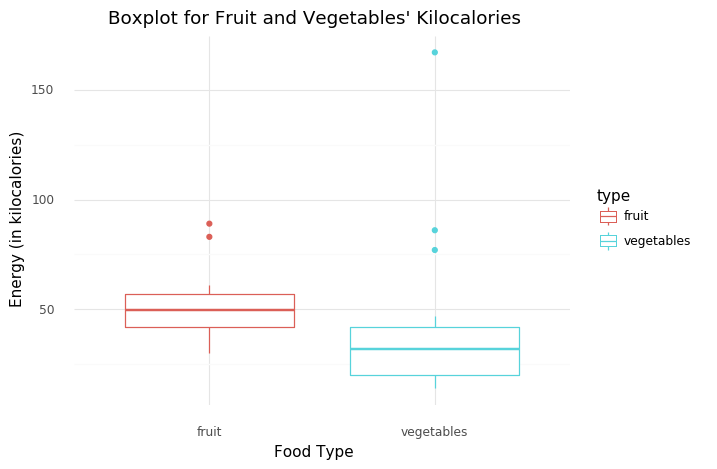

<ggplot: (-9223372029299855644)>

In [21]:
# Make boxplot
(
ggplot(energy_data, aes(x = 'type', y = "energy", color = "type")) +
    geom_boxplot() +
    labs(title = "Boxplot for Fruit and Vegetables' Kilocalories", x = "Food Type", y = "Energy (in kilocalories)") +
    theme_minimal()
)

In [22]:
# subset data by group
energy_data_fruit = energy_data[energy_data.loc[:,"type"] == 'fruit']
energy_data_vegetables = energy_data[energy_data.loc[:,"type"] == "vegetables"]

# calculate mean kilocalories for each group
energy_mean = pd.DataFrame({"fruit mean": [np.mean(energy_data_fruit.loc[:,"energy"])], 
 "vegetables mean" :[np.mean(energy_data_vegetables.loc[:,"energy"])]})

# check max vegetable energy
energy_data_vegetables.loc[energy_data_vegetables["energy"].idxmax()]

food        avocados
type      vegetables
energy           167
Name: 42, dtype: object

__Conclusion__

From the boxplot above we can see that fruit has a overall higher kilocalories for the following reasons.

* Conclusion can be made based on the difference in overall distribution of kilocalories between fruits and vegetables. From the boxplot, we can see that the distribution of kilocalories in fruit is very compact and roughly symmetric. On the other hand, the distribution of kilocalories for vegetables are overall at a lower level and not as compact compare to that of fruit. Plus, the distribution of kilocalories for vegetables slightly skered to the lower part. In addition, the median of fruit is higher than that of vegetables. Therefore, we can conclude that, overall, fruits have higher kilocalories than vegetables. 

* The median, Q1, Q3 of kilocalories of fruit are higher than that of vegetables. Notice that althgouth the maximum kilocalories for vegetables is higher than that of fruit and vegetables seem to have a wider range of kilocalories for food that have energy above the median, fruit still has higher Q1, Q3, and median, which indicates that, __OVERALL__, fruit has a higher kilocalories than vegetables. 

* The same conclusion can be drawn if we look at the mean of this two types of food. As calculated above, the mean of kilocalories for all fruits is 50.083333 kcal which is considerably higher than the mean kilocalories for vegetables, which is 39.8 kcal. Notice that, although both fruit and vegetables have two outliers, one of the outliers for vegetables, avocados, has an energy of 167 kcal, which is siginificantly higher than the outliers of fruits. Yet, the fact that fruit still has a high mean in energy indicates that, __OVERALL__, fruits indeed have a higher kilocalories than vegetables. 

## Question II ##
Which food provides the widest variety of nutrients?

In [23]:
# Function to get number of nutrients of every food
def get_number_nutrient(food):
    '''This function takes in a food name and returns its nutrients value and unit.
    The food name should be a string. Invalid food name will result in the function returning an empty list'''
    # get ndbnumber
    ndb_number = fresh[fresh.loc[:,'food'] == food].loc[:,"ndb_number"]
    all_result = ndb_report(ndb_number)
    # get the length of the report, which indicates that number of nutrients in each food
    if len(all_result) > 0:
        values = [ele["value"] + " " + ele["unit"] for ele in all_result]
        return(values)
    else:
        return([])

In [24]:
food_nutrient_num = list(food_name.apply(get_number_nutrient))

In [25]:
# calcualte nutrient amount (only account for nutrients with unit "g" or "mg", smaller unit neglected)
nutrient_amount = []
for lst in food_nutrient_num:
    amount = []
    for ele in lst:
        full = ele.split()
        unit = full[-1]
        # only calculate nutrients that have unit g or mg
        if unit in ["g", "mg"]:
            value = float(full[0])
            # add value based on its unit
            if unit == "g":
                amount.append(value * 1000)
            else:
                amount.append(value)
    lst_sum = sum(amount)
    # convert unit back to gram
    nutrient_amount.append(lst_sum/1000) 

In [26]:
# get the number of types of nutrients each food has
variety = []
for lst in food_nutrient_num:
    amount = 0
    for ele in lst:
        value = float(ele.split()[0])
        # check number of nutrients whose value is not 0
        if value > 0.000001:
            amount = amount + 1
        else:
            continue
    # add number of types of nutrient in the right order
    variety.append(amount)
        

In [27]:
# slice dataset for plotting
fresh_nutrient_variaty = fresh.loc[:,["food","type"]]
fresh_nutrient_variaty.loc[:,"variety"] = variety
fresh_nutrient_variaty.loc[:,'amount'] = nutrient_amount

In [28]:
# sort the dataset for better plotting
fresh_nutrient_variaty = fresh_nutrient_variaty.sort_values(['variety', 'type', 'amount'])

In [29]:
# get fruit with most type of nutrients
nutrient_max = max(fresh_nutrient_variaty.loc[:,"variety"])
nutrient_max

27

In [30]:
# find food with maximum type of nutrients
fresh_max = fresh_nutrient_variaty[fresh_nutrient_variaty.loc[:,"variety"] == nutrient_max]
len(fresh_max.loc[:,"food"])

34

In [31]:
# check sample size
subject_num = fresh.shape[0]
subject_num

49

In [32]:
# check on mean nutrient amount for fruits and vegetables whose types of nutrients is 27
max_nutrient = fresh_nutrient_variaty.loc[fresh_nutrient_variaty['variety'] == 27]

In [33]:
# calculate mean nutrient amount for fruit
max_fruit = max_nutrient.loc[max_nutrient['type'] == 'fruit']
fruit_amount = np.mean(max_fruit.loc[:,'amount'])
fruit_amount

110.959182875

In [34]:
# calculate mean nutrient amount for vegetables
max_vege = max_nutrient.loc[max_nutrient['type'] == 'vegetables']
vege_amount = np.mean(max_vege.loc[:,'amount'])
vege_amount

105.2459962777778

Text(0.5, 1.0, 'Food and its Variety of Nutrients')

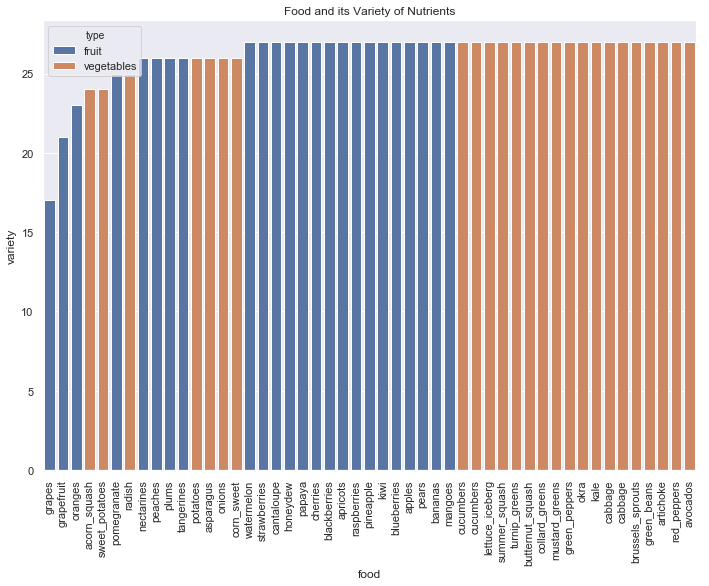

In [35]:
# Visualize using seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})
# sort index
nutrient_plt = sns.barplot(x = 'food', y = 'variety',
                           hue = 'type',
                           data = fresh_nutrient_variaty,
                           order = fresh_nutrient_variaty["food"],
                           dodge=False)
# rotate x-axis label for better view
nutrient_plt.set_xticklabels(nutrient_plt.get_xticklabels(), rotation = 90)
# add title
nutrient_plt.set_title('Food and its Variety of Nutrients')

__conclusion I__

From this plot, we can see that the vast majority of foods (34 out of 49) have the same amount of nutrients, 27, which also appears to be the maxiumum amount of nutrients that food from this dataset contains. Therefore, there are 27 foods that have the maxiumum range of nutrients available. According to this plot, we can see that for the 34 foods that have the maximum amount of nutrients, roughly half of them are fuits and the other half of foods are vegetables. Thus, fruits and vegetables do not seem to differ a lot in terms of the variety of nutrients. Yet, this conclusion does not provide much of useful information considering its wide range (34 out of 49). Therefore, to be more precise and to provide more information, the amount of nutrients available in each food is also calculated to have a more price ranking and to provide more insights on this question.

In [36]:
# sort the dataset for plotting
fresh_nutrient_variaty = fresh_nutrient_variaty.sort_values(['variety', 'amount'])

Text(0.5, 1.0, 'Food and its Amount of Nutrients (In gram)')

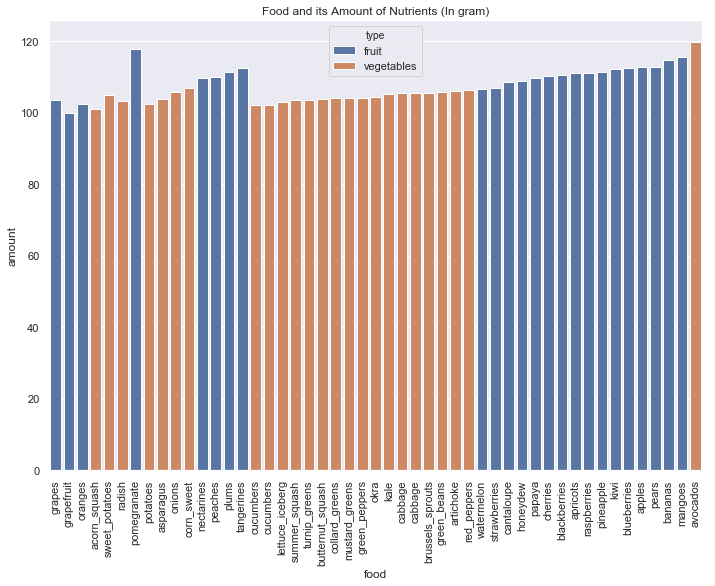

In [37]:
# Visualize using seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})
# sort index
nutrient_plt = sns.barplot(x = 'food', y = 'amount', 
                           hue = 'type',
                           data = fresh_nutrient_variaty,
                           order = fresh_nutrient_variaty['food'],
                           dodge=False)
nutrient_plt.set_xticklabels(nutrient_plt.get_xticklabels(), rotation = 90)
nutrient_plt.set_title('Food and its Amount of Nutrients (In gram)')

In [38]:
# check info of pomegranate
fresh_nutrient_variaty.loc[fresh_nutrient_variaty['food'] == "pomegranate"]

,food,type,variety,amount
7,pomegranate,fruit,25,117.740938


__Conclusion II__

This plot shows the ranking of the amount of nutrients that the food contains. Notice that the data is grouped by its variety of nutrients so there are some food that have large amount of nutrients but were ranked low since they do not have as many types of nutrients as the higher ranked foods. First of all, a limitation of this plot is that nutrients with small unit (e.g. $\mu$g) is neglected (only considered units "g" and "mg"). These neglected units, however, are tiny and should not show any effect on our result. From the plot we can see that both vegetables and fruits have roughly same amoung of nutrients. However, for foods that have 27 (maximum) nutrients, it appears that fruit generally has higher nutrient amount than vegetables. Besides nutrient amount for avocado is much higher than that of other vegetables (whether avocado is fruit or vegetable is also debatable), the nutrient amount for all other vegetables that have 27 nutrients appears to be smaller than all fruits with 27 nutrients (the highest nutrient amount in vegetables appeats to be smaller or equal to the amount for fruit). By checking the mean of nutrient content in both fruit and vegetables, our observation is confirmed. It turns out that the mean nurtient content of fruit is 110.959182875g which is higher than that of vegetables, which is 105.2459962777778g. Therefore, it is safe to conclude that fruit generally contains more nutrient than vegetables.

In addition, our conclusion can be further ensured by obsserving that, although some fruits contain less than 27 nutrients, they still have a large amount of nutrients available. For instance, from the graph, we can see that the fruit *pomegranate* contains a large amount of nutrients. It turns out that pomegranate has 25 nutrients by the amount of these nutrients is 117.740938g, which is higher than the average amount for both vegetables and fruits that contain 27 nutrients. Therefore, we have sufficient evidence to conclude that fruit is generally more nutritious than vegetables.

Another limitation about this conclusion is that this conclusion is drawn completely based on the dataset **fresh.csv**, which obviously does not contain all fruits and vegetables. Thus, this data could be biased and so does the conclusion. Therefore, this test is better conducted on datasets that contains information on most vegetables and fruits in order to get a more reliable result.